<a href="https://colab.research.google.com/github/IvanLudvig/mlmipt/blob/master/torchvision/zalando.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import nltk
from nltk.corpus import stopwords
import torch.nn as nn
import torch
from torchvision import datasets, models, transforms
from PIL import Image
import torchvision
import time
import os
from torch.utils.data import Dataset
from sklearn.preprocessing import MultiLabelBinarizer
import sklearn.metrics as metrics

In [2]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('brown')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


True

In [3]:
df = pd.read_csv('/content/drive/MyDrive/ml/zalando_english_1.csv')

In [4]:
def extract_nouns(text):
  tokenized = nltk.word_tokenize(text)
  return [word.lower() for (word, pos) in nltk.pos_tag(tokenized) if pos[:2] == 'NN']

def extract_adjs(text):
  tokenized = nltk.word_tokenize(text)
  return [word.lower() for (word, pos) in nltk.pos_tag(tokenized) if pos[:2] == 'JJ']

df['nouns'] = df['descriptions'].apply(lambda v: extract_nouns(v))
df['adjs'] = df['descriptions'].apply(lambda v: extract_adjs(v))

In [5]:
df.head()

,Unnamed: 0,level_0,index,url,descriptions,split,nouns,adjs
0,0,0,0,https://i2.ztat.net/large/Y0/32/1C/00/UE/11/Y0...,"short, sexy, summer, sexy, party, yellow dress...",7,"[summer, sexy, party, dress, sleeves, yellow, ...","[short, sexy, yellow, shoulder-free, fabric, y..."
1,1,1,1,https://i6.ztat.net/large/V1/02/1C/0T/QK/11/V1...,blue knee-length ladies dress with white dots ...,6,"[ladies, dress, dots, pattern, round, neckline...","[blue, knee-length, white, short, white, polka..."
2,2,2,2,https://i6.ztat.net/large/TF/72/1C/01/5K/11/TF...,This product is a dress. It's striped gray and...,2,"[product, dress, blue, beach, dress, knees, ro...","[striped, gray, white, light, white, gray, whi..."
3,3,3,3,https://i2.ztat.net/large/VE/12/1C/14/9C/11/VE...,Thigh-length fabric dress in gray with hip poc...,7,"[thigh-length, fabric, dress, pockets, round, ...","[gray, hip, elbow-length, casual, three-fold, ..."
4,4,4,4,https://i6.ztat.net/large/S2/92/1C/0B/AK/11/S2...,It is an elegant dark blue medium length dress...,7,"[dark, medium, length, dress, sleeves, top, ro...","[elegant, blue, black, figure-hugging, knee-le..."


In [6]:
def top_tags(tags):
    counter = TfidfVectorizer(analyzer='word', stop_words='english')
    try:
      counter.fit(tags)
    except ValueError:
      return []

    matrix_count = counter.fit_transform(tags).toarray()
    scores = matrix_count.sum(axis=1)
    sorted_ids = np.argsort(scores).flatten()[::-1]

    return np.array(tags)[sorted_ids[:10]]

df['nouns'] = df['nouns'].apply(lambda x: top_tags(x))
df['adjs'] = df['adjs'].apply(lambda x: top_tags(x))

In [7]:
num_classes = 25
all_nouns = df['nouns'].to_numpy()
all_nouns = np.concatenate(all_nouns)
values, counts = np.unique(all_nouns, return_counts=True)

ind = np.argpartition(-counts, kth=num_classes)[:num_classes]
noun_classes = values[ind]
noun_classes

array(['knee', 'sleeves', 'arms', 'length', 'round', 'collar', 'mini',
       'waist', 'sleeveless', 'dress', 'belt', 'v-neck', 'summer',
       'pattern', 'cut', 'knees', 'skirt', 'blue', 'neckline',
       'knee-length', 'straps', 'lace', 'shoulders', 'neck', 'fabric'],
      dtype='<U27')

In [8]:
num_classes = 30
all_adjs = df['adjs'].to_numpy()
all_adjs = np.concatenate(all_adjs)
values, counts = np.unique(all_adjs, return_counts=True)

ind = np.argpartition(-counts, kth=num_classes)[:num_classes]
adjs_classes = values[ind]
adjs_classes

array(['tight', 'narrow', 'blue', 'white', 'small', 'floral', 'free',
       'wide', 'half-length', 'sleeveless', 'medium-length', 'light',
       'gray', 'deep', 'long', 'red', 'black', 'shoulder-free', 'dark',
       'knee-length', 'colorful', 'figure-hugging', 'short', 'mid-thigh',
       'large', 'high', 'elegant', 'green', 'fabric', 'floor-length'],
      dtype='<U27')

In [9]:
df['nouns'] = df['nouns'].map(lambda v: noun_classes[np.in1d(noun_classes, v)]).values
df['adjs'] = df['adjs'].map(lambda v: adjs_classes[np.in1d(adjs_classes, v)]).values

In [10]:
df = df[df['nouns'].map(len) >= 1]
df = df[df['adjs'].map(len) >= 1]

In [ ]:
!unzip /content/drive/MyDrive/ml/zalando_img_224.zip

In [12]:
loaded_images = []

my_transforms = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

for i, url in enumerate(df['url'].values):
    filename = url.split('/')[-1]
    img = Image.open(f"/content/zalando_img_224/{filename}")
    img_tensor = my_transforms(img.convert('RGB'))
    loaded_images.append(img_tensor)

In [13]:
len(loaded_images)

8789

In [14]:
df

,Unnamed: 0,level_0,index,url,descriptions,split,nouns,adjs
0,0,0,0,https://i2.ztat.net/large/Y0/32/1C/00/UE/11/Y0...,"short, sexy, summer, sexy, party, yellow dress...",7,"[sleeves, length, dress, knee-length, straps]","[wide, sleeveless, deep, shoulder-free]"
1,1,1,1,https://i6.ztat.net/large/V1/02/1C/0T/QK/11/V1...,blue knee-length ladies dress with white dots ...,6,"[sleeves, round, dress, pattern, skirt, blue, ...","[white, knee-length, short]"
2,2,2,2,https://i6.ztat.net/large/TF/72/1C/01/5K/11/TF...,This product is a dress. It's striped gray and...,2,"[round, dress, knees, blue, neckline]","[white, small, gray, black]"
3,3,3,3,https://i2.ztat.net/large/VE/12/1C/14/9C/11/VE...,Thigh-length fabric dress in gray with hip poc...,7,"[sleeves, length, round, dress, neckline, fabric]","[half-length, light, gray, short]"
4,4,4,4,https://i6.ztat.net/large/S2/92/1C/0B/AK/11/S2...,It is an elegant dark blue medium length dress...,7,"[sleeves, length, round, dress, cut, neckline,...","[blue, dark, knee-length, figure-hugging, short]"
...,...,...,...,...,...,...,...,...
8787,8787,8787,8788,https://i1.ztat.net/large/GS/12/1C/04/NC/11/GS...,It is a military green dress with a round neck...,0,"[round, sleeveless, dress, neckline]","[wide, sleeveless, deep, long, dark]"
8788,8788,8788,8789,https://i2.ztat.net/large/MF/92/1C/0D/OK/11/MF...,"Short blue mini dress with knotted straps, sle...",8,"[length, mini, sleeveless, dress, blue, neckli...","[free, black, short, mid-thigh]"
8789,8789,8789,8790,https://i5.ztat.net/large/V1/02/1C/0Q/8M/11/V1...,green dress it has a wide round collar and a s...,3,"[sleeves, round, dress, summer, skirt, necklin...","[wide, figure-hugging, short, high, green, fab..."
8790,8790,8790,8791,https://i5.ztat.net/large/GL/92/1C/06/SK/11/GL...,Thigh-length fabric dress in blue with white p...,9,"[sleeves, round, dress, neckline, knee-length]","[blue, white, wide, gray, long]"


In [15]:
batch_size = 100
num_workers = 8

class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = torch.Tensor(targets)
        # self.targets = torch.from_numpy(targets)
        # self.targets = targets
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = Image.fromarray(self.data[index].astype(np.uint8).transpose(1,2,0))
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.data)

In [16]:
mlb = MultiLabelBinarizer()
y = pd.DataFrame(mlb.fit_transform(df['adjs']), columns=mlb.classes_)
y.head()

,black,blue,colorful,dark,deep,elegant,fabric,figure-hugging,floor-length,floral,free,gray,green,half-length,high,knee-length,large,light,long,medium-length,mid-thigh,narrow,red,short,shoulder-free,sleeveless,small,tight,white,wide
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
4,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [17]:
y = y.to_numpy()

x_train, x_test, y_train, y_test = train_test_split(loaded_images, y, test_size=0.3, random_state=42)

train_dataset = MyDataset(x_train, y_train)
dataloader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

test_dataset = MyDataset(x_test, y_test)
dataloader_test = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

image_datasets = {'train': x_train, 'val': x_test}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

dataloaders = {'train': dataloader_train, 'val': dataloader_test}

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [18]:
input_size = 224
num_classes = len(mlb.classes_)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [20]:
def calculate_metrics(pred, target, threshold=0.5):
    pred = np.array(pred > threshold, dtype=float)
    return {
            'micro/f1': metrics.f1_score(y_true=target, y_pred=pred, average='micro'),
            'macro/f1': metrics.f1_score(y_true=target, y_pred=pred, average='macro'),
            'samples/f1': metrics.f1_score(y_true=target, y_pred=pred, average='samples'),
            }


In [21]:
class Resnext50(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        resnet = models.resnext50_32x4d(pretrained=True)
        resnet.fc = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=resnet.fc.in_features, out_features=n_classes)
        )
        self.base_model = resnet
        self.sigm = nn.Sigmoid()

    def forward(self, x):
        return self.sigm(self.base_model(x))

model = Resnext50(num_classes)
model = model.to(device)
model.train()

Downloading: "https://download.pytorch.org/models/resnext50_32x4d-7cdf4587.pth" to /root/.cache/torch/hub/checkpoints/resnext50_32x4d-7cdf4587.pth


Resnext50(
  (base_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): 

In [22]:
max_epoch_number = 10
learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

In [23]:
def checkpoint_save(model, epoch):
    f = os.path.join('/content/drive/MyDrive/ml/zalando_checkpoints/', 'checkpoint-{:06d}.pth'.format(epoch))
    if 'module' in dir(model):
        torch.save(model.module.state_dict(), f)
    else:
        torch.save(model.state_dict(), f)
    print('saved checkpoint:', f)

In [24]:
epoch = 0
iteration = 0
test_freq = 5
save_freq = 1
while True:
    batch_losses = []
    for imgs, targets in dataloaders['train']:
        imgs, targets = imgs.to(device), targets.to(device)

        optimizer.zero_grad()

        model_result = model(imgs)
        loss = criterion(model_result, targets.type(torch.float))

        batch_loss_value = loss.item()
        loss.backward()
        optimizer.step()

        batch_losses.append(batch_loss_value)

        if iteration % test_freq == 0:
            model.eval()
            with torch.no_grad():
                model_result = []
                targets = []
                for imgs, batch_targets in dataloaders['train']:
                    imgs = imgs.to(device)
                    model_batch_result = model(imgs)
                    model_result.extend(model_batch_result.cpu().numpy())
                    targets.extend(batch_targets.cpu().numpy())

            result = calculate_metrics(np.array(model_result), np.array(targets))
            print("epoch:{:2d} iter:{:3d} test: "
                  "micro f1: {:.3f} "
                  "macro f1: {:.3f} "
                  "samples f1: {:.3f}".format(epoch, iteration,
                                              result['micro/f1'],
                                              result['macro/f1'],
                                              result['samples/f1']))

            model.train()
        iteration += 1

    loss_value = np.mean(batch_losses)
    print("epoch:{:2d} iter:{:3d} train: loss:{:.3f}".format(epoch, iteration, loss_value))
    if epoch % save_freq == 0:
        checkpoint_save(model, epoch)
    epoch += 1
    if max_epoch_number < epoch:
        break


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch: 0 iter:  0 test: micro f1: 0.247 macro f1: 0.069 samples f1: 0.244
epoch: 0 iter:  5 test: micro f1: 0.358 macro f1: 0.113 samples f1: 0.343
epoch: 0 iter: 10 test: micro f1: 0.393 macro f1: 0.145 samples f1: 0.381
epoch: 0 iter: 15 test: micro f1: 0.318 macro f1: 0.090 samples f1: 0.327
epoch: 0 iter: 20 test: micro f1: 0.445 macro f1: 0.242 samples f1: 0.431
epoch: 0 iter: 25 test: micro f1: 0.410 macro f1: 0.199 samples f1: 0.383
epoch: 0 iter: 30 test: micro f1: 0.406 macro f1: 0.190 samples f1: 0.399
epoch: 0 iter: 35 test: micro f1: 0.465 macro f1: 0.244 samples f1: 0.458
epoch: 0 iter: 40 test: micro f1: 0.499 macro f1: 0.284 samples f1: 0.494
epoch: 0 iter: 45 test: micro f1: 0.475 macro f1: 0.256 samples f1: 0.470
epoch: 0 iter: 50 test: micro f1: 0.505 macro f1: 0.264 samples f1: 0.497
epoch: 0 iter: 55 test: micro f1: 0.494 macro f1: 0.243 samples f1: 0.492
epoch: 0 iter: 60 test: micro f1: 0.494 macro f1: 0.256 samples f1: 0.490
epoch: 0 iter: 62 train: loss:0.328
sa

In [25]:
# checkpoint = torch.load(os.path.join('/content/drive/MyDrive/ml/zalando_checkpoints/', 'checkpoint-{:06d}.pth'.format(10)))
# model.load_state_dict(checkpoint)

In [26]:
def imshow(inputs, title=None):
    img = inputs.transpose(1, 2, 0)
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)

In [27]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            preds = outputs.cpu()

            if preds.numpy() is None:
              continue

            preds = np.array(preds)[0]
            plt.subplot(2, 3, i + 1)
            plt.axis('off')

            top3 = -np.sort(-preds)[min(2, len(preds)-1)]
            preds[preds < top3] = 0
            preds[preds >= top3] = 1

            tags = mlb.inverse_transform(np.array([preds]))[0][:3]
            tags_real = mlb.inverse_transform(np.array([y_test[i]]))[0][:3]
            plt.title('Predicted: ' + ', '.join(map(str, tags)) + '\n' + 'Real: ' + ', '.join(tags_real))
            img = np.array(inputs.cpu().data[i])
            img = img.transpose(1, 2, 0)
            mean = np.array([0.5, 0.5, 0.5])
            std = np.array([0.5, 0.5, 0.5])
            img = std * img + mean
            img = np.clip(img, 0, 1)
            plt.imshow(img)

            if i >= num_images - 1:
                return

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


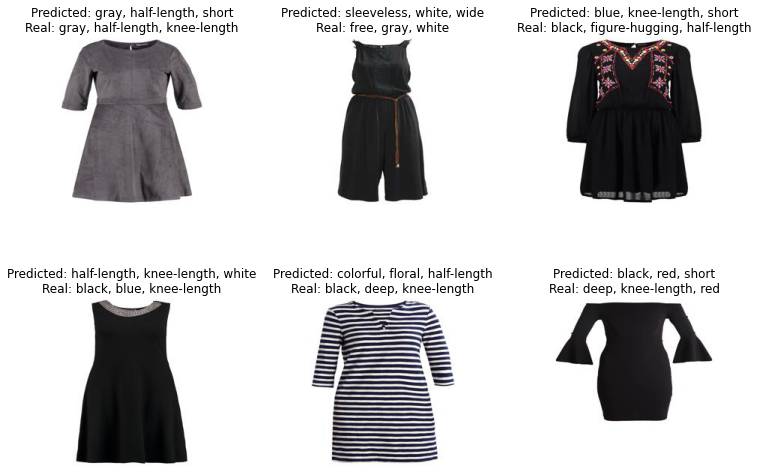

In [28]:
fig, ax = plt.subplots(figsize=(12,8))
plt.subplots_adjust(hspace=.5, wspace=.5)
visualize_model(model)